In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools

In [43]:
def bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    
    z_tilde_train_ols_aux = np.empty(n)
    z_tilde_test_ols_aux = np.empty(n)
    
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
               
        z1_train = z_train[sequence]  
        
        
        z_tilde_train_ols_aux , z_tilde_test_ols_aux = OLS(X1_train, X_test, z1_train)
        
        MSE[i,0] = mean_squared_error(z1_train, z_tilde_train_ols_aux) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols_aux)  
        
    return z_tilde_train_ols_aux, z_tilde_test_ols_aux, MSE

def OLS(X_train, X_test, z_train):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set

    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)

    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)
    z_train_tilde_ols = target_scaler.inverse_transform(z_train_tilde_ols)
    z_test_tilde_ols = target_scaler.inverse_transform(z_test_tilde_ols)
    
    return z_train_tilde_ols, z_test_tilde_ols



def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    # Scaling
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set

    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)              # Not necessary because we dont compute MSE here
    z_tilde_train = target_scaler.inverse_transform(z_tilde_train)
    z_tilde_test = target_scaler.inverse_transform(z_tilde_test)
    
    return z_tilde_train, z_tilde_test

def bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    n = len(z_train)
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))

    
    z_tilde_train_aux = np.empty(n)
    z_tilde_test_aux = np.empty(n)
    
    
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train_aux , z_tilde_test_aux = Ridge(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_aux)
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_aux)
    
        
    return z_tilde_train_aux, z_tilde_test_aux, MSE

def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)

    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge( X_train, X_test, z_train, z_test, lambd)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_Ridge))

    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    
    return MSE_train_mean, MSE_test_mean

def cross_validation_OLS(k_folds, X, z):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]
        
        X_test = X[test_inds]
        z_test = z[test_inds]
        
        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_ols))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_ols))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def RegressionSigma2 (yobs,ypred,n_params):
    n = yobs.shape[0]
    return np.sum((yobs-ypred)**2)/(n-n_params)

def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X



In [44]:
#Defination of functions with PCA 
def drop_columns(boston_df, low_thresh, high_thresh=1, show=False):
    ''' Function takes in a value of thresholding and return the filtered dataframe, excluding already the target columns'''
    
    
    #print the correlation matrix
    corr_matrix = boston_df.corr().round(2)
    
    #show correlation matrix
    if show:
        sns.heatmap(data=corr_matrix, annot=True)
        
    array_corr = corr_matrix["MEDV"].abs()
    indices = np.arange(array_corr.shape[0])
    
    col_indi = indices[(array_corr < low_thresh) | (array_corr >= high_thresh)]
    
    display(corr_matrix)
    
    #eliminating colinearity by selecting only one of more highly correlated features
    
    #colinearity threshold
    colin_thresh = 0.75
    
    colin_vars = []
    
    for ind,col in itertools.product(corr_matrix.columns,corr_matrix.index):
        if (abs(corr_matrix[ind][col])>colin_thresh and ind !=col):
            colin_vars.append((ind,col))
            
    colin_used = []
    for (ind1,ind2) in colin_vars:
        if not (ind1 in colin_used or ind2 in colin_used):
            colin_used.append(ind1)
    print(colin_used)
    
    filtered_boston = boston_df.drop(boston_df.columns[col_indi], axis=1).drop(colin_used, axis=1)
    
    print(filtered_boston.columns,filtered_boston.shape)
    
    return filtered_boston


def OLS_PCA(X_train, X_test, z_train):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)

    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)
    z_train_tilde_ols = target_scaler.inverse_transform(z_train_tilde_ols)
    z_test_tilde_ols = target_scaler.inverse_transform(z_test_tilde_ols)
    
    return z_train_tilde_ols, z_test_tilde_ols

def Ridge_PCA(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    
    # Scaling
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # # Apply the transform to both the training set and the test set
    pca=PCA(n_components=0.95)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    z_train =np.asarray(z_train)                  # Series to array
    z_train = z_train.reshape(len(z_train),1)     # Reshape because standard scaler expects 2D

    target_scaler = StandardScaler()
    target_scaler.fit(z_train)
    z_train= target_scaler.transform(z_train)
    
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    
    # Do the inverse transformation to compare the targets and find the MSE
        
    z_train = target_scaler.inverse_transform(z_train)              # Not necessary because we dont compute MSE here
    z_tilde_train = target_scaler.inverse_transform(z_tilde_train)
    z_tilde_test = target_scaler.inverse_transform(z_tilde_test)
    
    return z_tilde_train, z_tilde_test

def cross_validation_Ridge_PCA(k_folds, X, z, lambd):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)

    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_Ridge, z_test_tilde_Ridge = Ridge_PCA( X_train, X_test, z_train, z_test, lambd)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_Ridge))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_Ridge))

    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    
    return MSE_train_mean, MSE_test_mean


def cross_validation_OLS_PCA(k_folds, X, z):
    MSE_train = []
    MSE_test = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]
        
        X_test = X[test_inds]
        z_test = z[test_inds]
        
        z_train_tilde_ols , z_test_tilde_ols = OLS_PCA(X_train, X_test, z_train)
        
        MSE_train.append(mean_squared_error(z_train, z_train_tilde_ols))
        MSE_test.append(mean_squared_error(z_test, z_test_tilde_ols))
        
    MSE_train_mean = np.mean(MSE_train)
    MSE_test_mean = np.mean(MSE_test)
    return MSE_train_mean, MSE_test_mean
    
def bootstrap_Ridge_PCA(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    n = len(z_train)
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))

    
    z_tilde_train_aux = np.empty(n)
    z_tilde_test_aux = np.empty(n)
    
    
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train_aux , z_tilde_test_aux = Ridge(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_aux)
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_aux)
        
    return z_tilde_train_aux, z_tilde_test_aux, MSE
                                      
def bootstrap_OLS_PCA(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    
    z_tilde_train_ols_aux = np.empty(n)
    z_tilde_test_ols_aux = np.empty(n)
    
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
               
        z1_train = z_train[sequence]  
        
        
        z_tilde_train_ols_aux , z_tilde_test_ols_aux = OLS_PCA(X1_train, X_test, z1_train)
        
        MSE[i,0] = mean_squared_error(z1_train, z_tilde_train_ols_aux) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols_aux)  
        
    return z_tilde_train_ols_aux, z_tilde_test_ols_aux, MSE

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def RegressionSigma2 (yobs,ypred,n_params):
    n = yobs.shape[0]
    return np.sum((yobs-ypred)**2)/(n-n_params)

def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X



/tmp/ipykernel_76337/3603778933.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


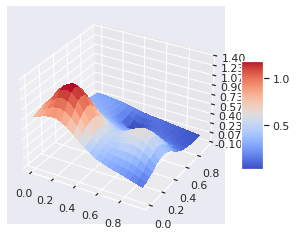

In [45]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [46]:
#number of points for each axis
n_points = 100

#set random seed
np.random.seed(53186)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(48643)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)

#generate normal distributed noise 
noise_amp = 0.2
noise = noise_amp*np.random.randn(X0.shape[0])

#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise


# The degree of the polynomial and the corresponding design matrix will be specific of each problem

par 0: 0.3 +/- 7.4 (95%)
par 1: 9.3 +/- 88.5 (95%)
par 2: 3.3 +/- 75.0 (95%)
par 3: -41.4 +/- 422.1 (95%)
par 4: -16.3 +/- 286.8 (95%)
par 5: -7.0 +/- 357.5 (95%)
par 6: 61.7 +/- 924.5 (95%)
par 7: 52.7 +/- 631.9 (95%)
par 8: 17.2 +/- 584.0 (95%)
par 9: -8.9 +/- 798.2 (95%)
par 10: -35.1 +/- 944.4 (95%)
par 11: -62.4 +/- 688.2 (95%)
par 12: -10.7 +/- 590.0 (95%)
par 13: -24.3 +/- 627.6 (95%)
par 14: 28.1 +/- 831.5 (95%)
par 15: 5.1 +/- 363.9 (95%)
par 16: 22.0 +/- 305.1 (95%)
par 17: 13.1 +/- 277.6 (95%)
par 18: -5.8 +/- 269.7 (95%)
par 19: 14.7 +/- 279.5 (95%)
par 20: -15.7 +/- 325.8 (95%)
The MSE test for OLS and degree  5
0.039912676076584636
MSE with intercept column from SKL
0.03991267607666492
The MSE train for OLS and degree  5
0.0420900494744452
R2 scores for 
Test  0.6645683957577108
Train 0.6350632785009878
The MSE test for OLS and degree(PCA)  5
0.039912676076584636
The MSE train for OLS and degree(PCA)  5
0.0420900494744452
R2 scores (PCA) for 
Test  0.6645683957577108
Trai

/tmp/ipykernel_76337/547769095.py:90: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


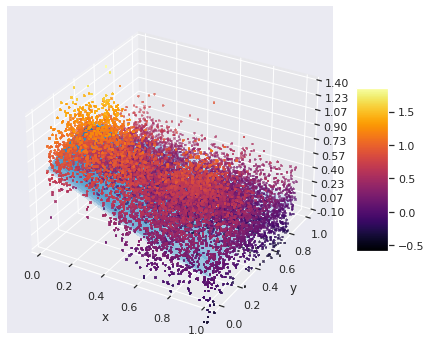

In [30]:
## THIS IS THE FIT CONSIDERING THE INTERCEPT (Intercept included in design matrix)


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=2)

# Intercept is included in the design matrix
skl = LinearRegression(fit_intercept=False).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)

#apply OLS regression
z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train)

z_train_tilde_ols_PCA, z_test_tilde_ols_PCA = OLS_PCA(X_train, X_test, z_train)

beta = skl.coef_

#variance of the target data
sigma2 = RegressionSigma2(z_train,z_train_tilde_ols,beta.shape[0])

#calculate covariance matrix of parameters
CovBeta = np.linalg.pinv(X.T @ X)
StdBeta = np.sqrt(sigma2*np.diag(CovBeta))

#confidence intervals at 95% (Gaussian assumed for betas)

CIBeta = np.zeros((beta.shape[0],2))
CIBeta[:,0] = beta - 2*StdBeta
CIBeta[:,1] = beta + 2*StdBeta

for i in range(beta.shape[0]):
    print("par {}: {:.1f} +/- {:.1f} (95%)".format(i,beta[i],StdBeta[i]))


#calculate train and test mse 
mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)
#Calculate the MSE using PCA 
mse_train_PCA = mean_squared_error(z_train,z_train_tilde_ols_PCA)
mse_test_PCA = mean_squared_error(z_test,z_test_tilde_ols_PCA)
#Calculate R2 using PCA 
r2_train_PCA = r2_score(z_train,z_train_tilde_ols_PCA)
r2_test_PCA = r2_score(z_test,z_test_tilde_ols_PCA)
#Print the results 
print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print("MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))

print("The MSE train for OLS and degree ",maxdegree)

print(mse_train)

print("R2 scores for ")

print("Test " , r2_test)
print("Train" , r2_train)

#PCA results

print("The MSE test for OLS and degree(PCA) ",maxdegree)
print(mse_test_PCA)



print("The MSE train for OLS and degree(PCA) ",maxdegree)

print(mse_train_PCA)

print("R2 scores (PCA) for ")

print("Test " , r2_test_PCA)
print("Train" , r2_train_PCA)

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

# Plot the surface.
surf_noise = ax.scatter3D(X[:,1],X[:,2], z, "o",c=z,cmap=cm.inferno, s=0.5,antialiased=False)
surf = ax.plot_surface(x, y, FrankeFunction(x, y),cmap="Blues", linewidth=0, antialiased=False,alpha=0.2)



# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("x")
ax.set_ylabel("y")

# Add a color bar which maps values to colors.
fig.colorbar(surf_noise, shrink=0.5, aspect=5)

plt.show()

In [47]:
#size of the initial dataset
nums_points = [50,70,100]

#std of the noise
noise_amps = [0.1,0.2,0.5]

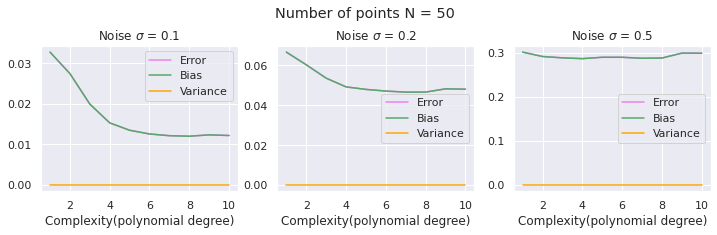

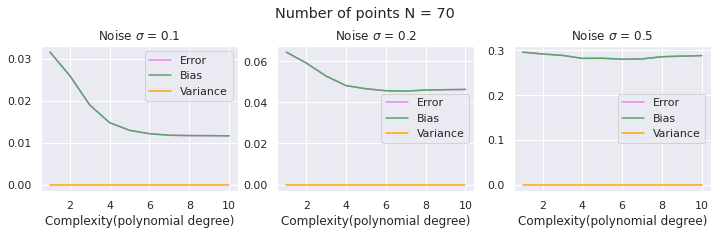

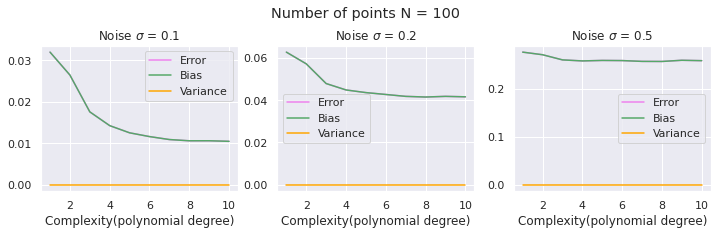

In [37]:
#maximum degree of polynomial
maxdegree = 10

#number of bootstrap resamplings
n_bs = 100
#create arrays for results
error = np.zeros((maxdegree,len(noise_amps)))
bias = np.zeros((maxdegree,len(noise_amps)))
variance = np.zeros((maxdegree,len(noise_amps)))
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))

#Here we define the figure:
for j in range(len(nums_points)):
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
    fig.subplots_adjust(top=0.8)
    
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[j])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[j])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    for i in range(len(noise_amps)):
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise
       
        for degree in range(maxdegree):

            X = create_X(x,y,degree + 1)
            
            # Why needed random_state
            # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=2)

            
            _, z_pred, mse = bootstrap_OLS_PCA(X_train, X_test, z_train, z_test, n_bs )
            z_t = z_test.reshape(len(z_test),1)
            
            polydegree[degree] = degree+1
            error[degree,i] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
            bias[degree,i] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[degree,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

            MSE_boot[degree, 0, i, j] = np.mean(mse[:,0]) 
            MSE_boot[degree, 1, i, j] = np.mean(mse[:,1])


        ax[i].plot(polydegree, error[:,i],color="violet", label='Error')
        ax[i].plot(polydegree,bias[:,i],color="g" ,label='Bias')
        ax[i].plot(polydegree, variance[:,i],color="orange", label='Variance')
        ax[i].set_xlabel('Complexity(polynomial degree)')
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

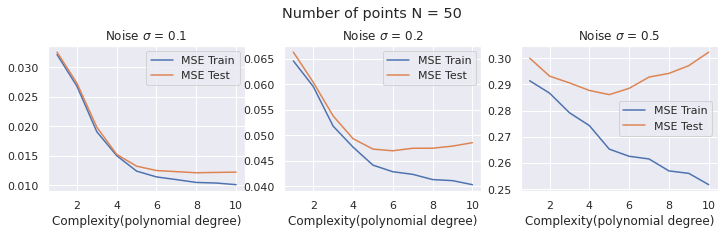

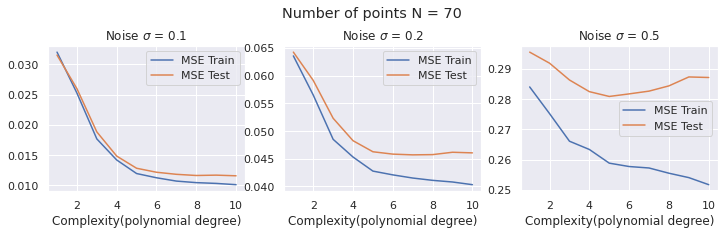

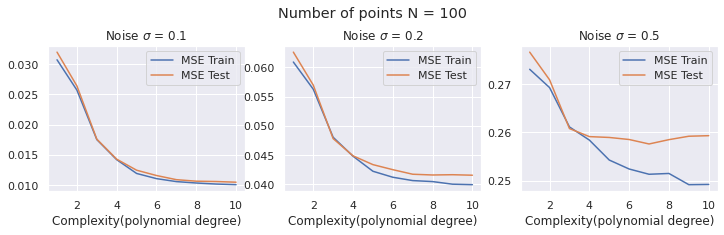

In [38]:
for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    fig.subplots_adjust(top=0.8)
    
    for i in range(len(noise_amps)):

        np.random.seed(127)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise

        ax[i].plot(polydegree, MSE_boot[:,0, i, j], label='MSE Train')
        ax[i].plot(polydegree, MSE_boot[:,1, i, j], label='MSE Test')
        ax[i].set_xlabel('Complexity(polynomial degree)')
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

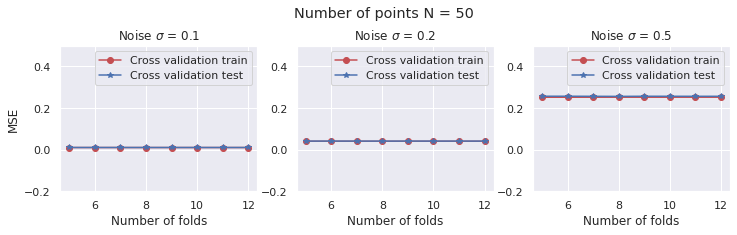

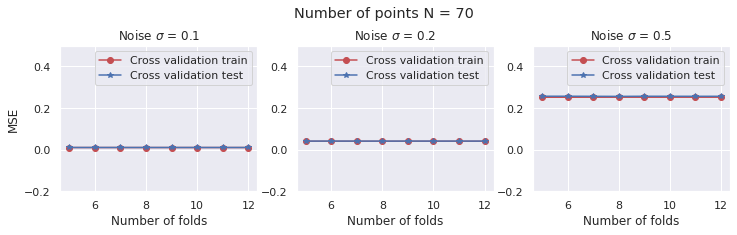

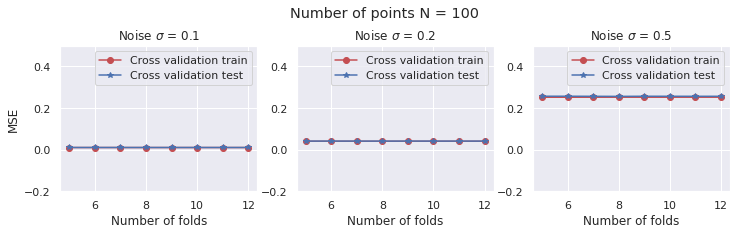

In [40]:
#maximum degree of polynomial
sel_degree = 12

k_folds = range(5,13)
#create arrays for results
MSE_cross = np.zeros((len(k_folds),2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
    fig.subplots_adjust(top=0.8)
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[i])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[i])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    for i in range(len(noise_amps)):
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise
        
        X = create_X(x,y,sel_degree)
        
        for k in range(len(k_folds)):
            MSE_cross[k,0,i,j], MSE_cross[k,1,i,j] = cross_validation_OLS_PCA(k_folds[k],X,z)


        ax[i].plot(k_folds,MSE_cross[:,0, i, j],"o-",c="r",label="Cross validation train")
        ax[i].plot(k_folds,MSE_cross[:,1, i, j],"*-",c="b",label="Cross validation test")
        ax[i].set_xlabel('Number of folds')
        ax[0].set_ylabel('MSE')
        plt.setp(ax[i], ylim=(-0.2,0.5))
        #plt.setp(ax[i], yscalez="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))


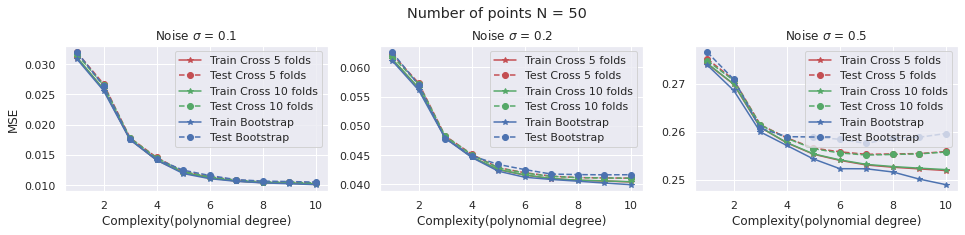

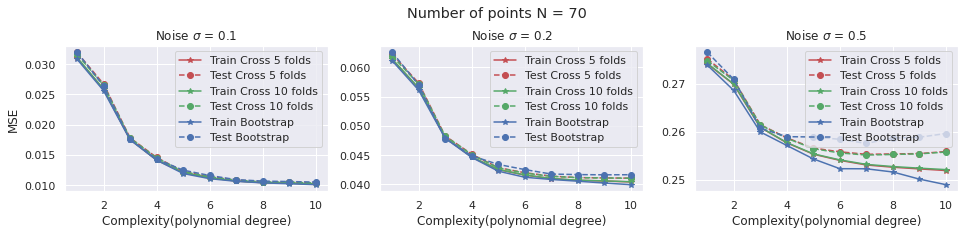

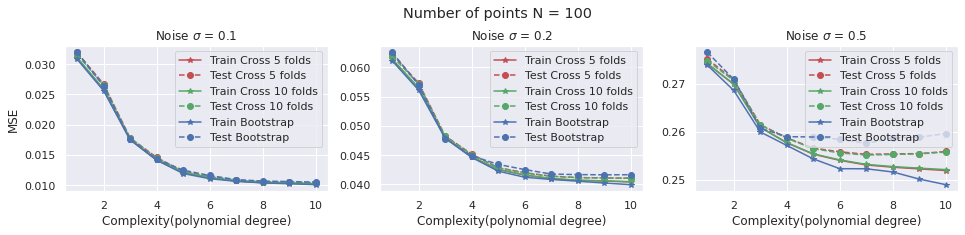

In [48]:
n_bs = 50
maxdegree = 10
#possibility for k folds
k_folds = [5,10]

#create arrays for results
MSE_cross = np.zeros((maxdegree,len(k_folds),2,len(noise_amps),len(nums_points)))

MSE_boot = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,len(noise_amps),figsize=(16,3))
    fig.subplots_adjust(top=0.8)
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[i])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[i])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    for i in range(len(noise_amps)):
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise
    
        for degree in range(maxdegree):

            X = create_X(x,y,degree+1)
    
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
            z_train_tilde_ols , z_test_tilde_ols = OLS_PCA(X_train, X_test, z_train)

            _, z_pred, mse = bootstrap_OLS_PCA(X_train, X_test, z_train, z_test, n_bs )
            z_t = z_test.reshape(len(z_test),1)
            MSE_boot[degree,0,i, j] = np.mean(mse[:,0])
            MSE_boot[degree,1,i, j] = np.mean(mse[:,1])
            for l in range(len(k_folds)):
                k = k_folds[l]
                MSE_cross[degree,l,0,i, j],MSE_cross[degree,l,1,i, j] = cross_validation_OLS_PCA(k,X,z)

        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,0,0, i, j],"r*-", label ='Train Cross 5 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,0,1, i, j],"ro--", label = 'Test Cross 5 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,1,0, i, j],"g*-", label ='Train Cross 10 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_cross[:,1,1, i, j],"go--", label = 'Test Cross 10 folds')
        ax[i].plot(range(1,maxdegree+1),MSE_boot[:,0, i, j],"b*-",label = 'Train Bootstrap')
        ax[i].plot(range(1,maxdegree+1),MSE_boot[:,1, i, j],"bo--",label = 'Test Bootstrap')
        
        ax[i].set_xlabel('Complexity(polynomial degree)')
        ax[0].set_ylabel('MSE')
        #plt.setp(ax[i], ylim=(1e-3,0.3))
        #plt.setp(ax[i], yscale="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.077426


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.077426


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.000003


/home/nucphys/miniconda3/envs/py3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77842e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lambda to obtain miminum MSE: 0.077426


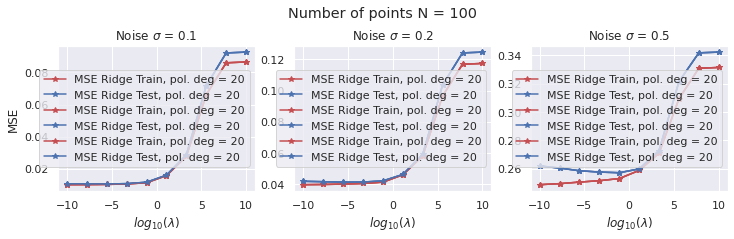

In [49]:
sel_degree = 20


#define interval of lambdas
nlambdas = 10
lambd = np.logspace(-10, 10, nlambdas)

#setup design matrix with polynomial model
X = create_X(x,y,sel_degree)


MSE_Ridge = np.zeros((len(lambd),2,len(noise_amps)))


fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
fig.subplots_adjust(top=0.8)

for j in range(len(nums_points)):
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[i])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[i])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    
    for i in range(len(noise_amps)):
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise


        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)

        for l in range(len(lambd)):
    
            z_tilde_train, z_tilde_test = Ridge_PCA(X_train,X_test,z_train,z_test,lambd[l])

            MSE_Ridge[l,0,i] = mean_squared_error(z_train, z_tilde_train)
            MSE_Ridge[l,1,i] = mean_squared_error(z_test, z_tilde_test)

        
        
        ax[i].plot(np.log10(lambd), MSE_Ridge[:,0,i], 'r*-', label = 'MSE Ridge Train, pol. deg = {}'.format(sel_degree))
        ax[i].plot(np.log10(lambd), MSE_Ridge[:,1,i], 'b*-', label = 'MSE Ridge Test, pol. deg = {}'.format(sel_degree))
        
        ax[i].set_xlabel('$log_{10}(\lambda)$')
        ax[0].set_ylabel('MSE')
        #plt.setp(ax[i], ylim=(1e-3,0.3))
        #plt.setp(ax[i], yscale="log")
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))
        
        print('Lambda to obtain miminum MSE: {:.6f}'.format(lambd[np.argmin(MSE_Ridge[:,1,i])]))

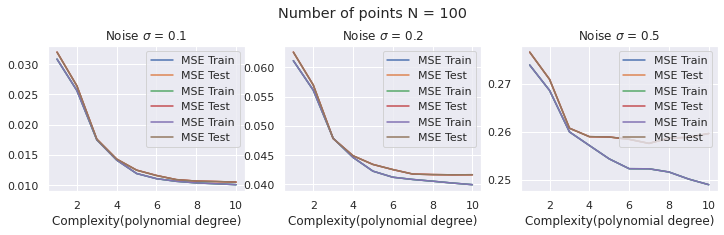

In [51]:
#Ridge
maxdegree = 10

nlambdas = 18 

lambdas = np.logspace(-1,2, nlambdas)

MSE_Ridge = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))

polydegree = np.zeros(maxdegree)

best_lambda = np.zeros(maxdegree)

mse_test_lambda = np.zeros(nlambdas)


fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
fig.subplots_adjust(top=0.8)

for j in range(len(nums_points)):
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[i])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[i])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    for i in range(len(noise_amps)):
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])
        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise
        for degree in range(maxdegree):

            X = create_X(x,y,degree + 1)

            # Why needed random_state
            # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=2)

            for l in range(nlambdas):
                z_tilde_train, z_tilde_test = Ridge_PCA(X_train,X_test,z_train,z_test,lambdas[l])
                mse_test_lambda[l] = mean_squared_error(z_test, z_tilde_test)
        
            best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
 
    
            z_tilde_train, z_tilde_test = Ridge_PCA(X_train,X_test,z_train,z_test,best_lambda[degree])
    
            polydegree[degree] = degree + 1
            
            MSE_Ridge[degree, 0, i, j] = np.mean(mse[:,0]) 
            MSE_Ridge[degree, 1, i, j] = np.mean(mse[:,1])
        
        ax[i].plot(polydegree, MSE_boot[:,0, i, j], label='MSE Train')
        ax[i].plot(polydegree, MSE_boot[:,1, i, j], label='MSE Test')
        ax[i].set_xlabel('Complexity(polynomial degree)')
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))

In [52]:
#Creating the desigen matrix, where I will choose 50 as the initial size of the data
np.random.seed(53186)
x0 = np.random.rand(50)

    #set random seed
np.random.seed(48643)
y0 = np.random.rand(50)

    #mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)
#calculate starting target values with nois, where I choose noise_amp=20 to obtain also good result
noise_amp = 0.2
np.random.seed(1231)
noise = noise_amp*np.random.randn(X0.shape[0])
z = FrankeFunction(X0[:,1],X0[:,2]) + noise

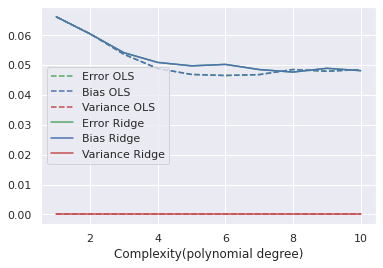

In [53]:
nlambdas = 18
lambdas = np.logspace(-1,2, nlambdas)

maxdegree = 10

n_bootstrap = 50

mse_test_lambda = np.zeros(nlambdas)

#prepare arrays for output

error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)

polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))
MSE_boot_ols = np.zeros((maxdegree,2))


#cycle on degrees of polynomial
for degree in range(maxdegree):
    
    #create design matrix (starting from degree 1)
    X = create_X(x,y,degree+1)
    #rescale design matrix

    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    for i in range(nlambdas):
        _,_, mse_ridge = bootstrap_Ridge_PCA(X_train, X_test, z_train, z_test, n_bootstrap, lambdas[i])
        mse_test_lambda[i] = np.mean(mse_ridge[:,1])
    
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]
    
    z_train_ridge, z_pred_ridge, mse_ridge = bootstrap_Ridge_PCA(X_train, X_test, z_train, z_test, n_bootstrap, best_lambda[degree])
    z_train_ols, z_pred_ols, mse_ols = bootstrap_OLS_PCA(X_train, X_test,z_train, z_test, n_bootstrap)
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    #calculate error, bias, variance for Ridge regression
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    
    #calculate error, bias, variance for OLS regression
    error_ols[degree] = np.mean( np.mean((z_t - z_pred_ols)**2, axis=1, keepdims=True) )
    bias_ols[degree] = np.mean( (z_t - np.mean(z_pred_ols, axis=1, keepdims=True))**2 )
    variance_ols[degree] = np.mean( np.var(z_pred_ols, axis=1, keepdims=True) )

    MSE_boot_ols[degree, 0] = np.mean(mse_ols[:,0]) 
    MSE_boot_ols[degree, 1] = np.mean(mse_ols[:,1]) 
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1])  
 
    
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

#plt.yscale("log")

plt.legend()
plt.show()


In [ ]:
plt.figure()
plt.plot(polydegree,MSE_boot_ols[:,0],"m-",label='MSE_Train OLS')
plt.plot(polydegree,MSE_boot_ols[:,1],"m--",label='MSE_Test OLS')
plt.plot(polydegree,MSE_boot_ridge[:,0],"g-",label='MSE_Train Ridge')
plt.plot(polydegree,MSE_boot_ridge[:,1],"g--",label='MSE_Test Ridge')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
n_bs = 50

maxdegree = 10
k_folds = [5,10]

MSE_train_cross = np.zeros((maxdegree,2))
MSE_test_cross = np.zeros((maxdegree,2))

nlambdas = 10 
lambdas = np.logspace(-1,2, nlambdas)

mse_test_lambda = np.zeros(nlambdas)


for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    
    
    z = z.reshape(len(z),1)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    for l in range(nlambdas):
        z_tilde_train, z_tilde_test = Ridge_PCA(X_train,X_test,z_train,z_test,lambdas[l])
        mse_test_lambda[l] = mean_squared_error(z_test, z_tilde_test)
        
        
    best_lambda[degree] = lambdas[np.argmin(mse_test_lambda)]

    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_train_cross[degree,i],MSE_test_cross[degree,i] = cross_validation_Ridge_PCA(k,X,z,best_lambda[degree])

plt.figure()
plt.plot(range(1,maxdegree+1),MSE_train_cross[:,0],"ro-", label ='Train Cross 5 folds' )
plt.plot(range(1,maxdegree+1),MSE_test_cross[:,0],"r*--", label = 'Test Cross 5 folds' )
plt.plot(range(1,maxdegree+1),MSE_train_cross[:,1],"go-", label ='Train Cross 10 folds' )
plt.plot(range(1,maxdegree+1),MSE_test_cross[:,1],"g*--", label = 'Test Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [18]:
#maximum degree of polynomial
maxdegree = 12


              
#create arrays for results
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2,len(noise_amps)))
R2_OLS = np.zeros((maxdegree,2,len(noise_amps)))



#define interval of lambdas
nlambdas = 20
lambd = np.logspace(-10, 10, nlambdas)


MSE_Ridge = np.zeros((len(lambd),2,len(noise_amps)))


fig,ax = plt.subplots(1,len(noise_amps),figsize=(12,3))
fig.subplots_adjust(top=0.8)

for i in range(len(noise_amps)):
    
    np.random.seed(3)
    noise = noise_amps[i]*np.random.randn(X0.shape[0])

    #calculate starting target values with noise
    z = FrankeFunction(X0[:,1],X0[:,2]) + noise

    for degree in range(maxdegree):

        X = create_X(x,y,degree+1)

        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_sc = scaler.transform(X_train)
        X_test_sc = scaler.transform(X_test)
        
        z_t = z_test.reshape(len(z_test),1)
        polydegree[degree] = degree+1

        z_train_tilde_ols , z_test_tilde_ols = OLS_PCA(X_train, X_test, z_train) 

        MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
        MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

        R2_OLS[degree, 0] = r2_score(z_train,z_train_tilde_ols)
        R2_OLS[degree, 1] = r2_score(z_test,z_test_tilde_ols)  



    #plot the results
    fig,ax = plt.subplots(1,2,figsize=(12,4))

    ax[0].plot(polydegree,MSE_OLS[:,0,i],label='MSE Train')
    ax[0].plot(polydegree,MSE_OLS[:,1,i],label='MSE Test')
    ax[0].set_xlabel('Complexity(polynomial degree)')
    plt.setp(ax[0], ylabel='MSE')
    ax[0].legend()

    ax[1].plot(polydegree,R2_OLS[:,0,i],label='R2 Train')
    ax[1].plot(polydegree,R2_OLS[:,1,i],label='R2 Test')
    plt.xlabel('Complexity(polynomial degree)')
    plt.setp(ax[1], ylabel='$R^2$')
    ax[1].legend()


    plt.suptitle("Noise $\sigma$ = {}".format(noise_amps[i]))

NameError: name 'pca' is not defined

NameError: name 'pca' is not defined

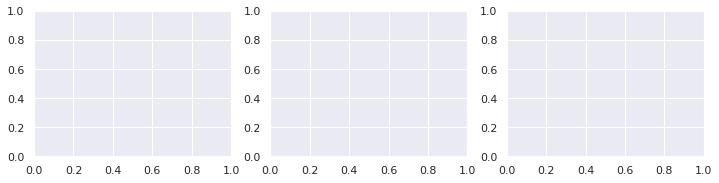

In [19]:
#For different initial set od data size 

nums_points = [15,20,25,30,40]

#std of the noise
noise_amps = [0.1,0.3,0.6]

#maximum degree of polynomial
maxdegree = 12

#number of bootstrap resamplings
n_bs = 100



#create arrays for results
error = np.zeros((maxdegree,len(noise_amps)))
bias = np.zeros((maxdegree,len(noise_amps)))
variance = np.zeros((maxdegree,len(noise_amps)))
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2,len(noise_amps),len(nums_points)))



for j in range(len(nums_points)):
    
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    fig.subplots_adjust(top=0.8)

    
    np.random.seed(53186)
    x0 = np.random.rand(nums_points[j])

    #set random seed
    np.random.seed(48643)
    y0 = np.random.rand(nums_points[j])

    #mesh arrays of x and y
    x,y = np.meshgrid(x0,y0)

    #create a dummy design matrix for the arrays of x and y
    X0 = create_X(x,y)
    
    
    for i in range(len(noise_amps)):

        
        np.random.seed(1231)
        noise = noise_amps[i]*np.random.randn(X0.shape[0])

        #calculate starting target values with noise
        z = FrankeFunction(X0[:,1],X0[:,2]) + noise

        z = z.reshape(len(z),1)

        #cycle on polynomial degrees

        for degree in range(maxdegree):

            X = create_X(x,y,degree + 1)

            # Why needed random_state
            # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
            X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=2)
    
            _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
        
            z_t = z_test.reshape(len(z_test),1)
            
            polydegree[degree] = degree+1
            error[degree,i] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
            bias[degree,i] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
            variance[degree,i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

            MSE_boot[degree, 0, i, j] = np.mean(mse[:,0]) 
            MSE_boot[degree, 1, i, j] = np.mean(mse[:,1])


        ax[i].plot(polydegree, error[:,i],color="violet", label='Error')
        ax[i].plot(polydegree,bias[:,i],color="g" ,label='Bias')
        ax[i].plot(polydegree, variance[:,i],color="orange", label='Variance')
        ax[i].set_xlabel('Complexity(polynomial degree)')
        plt.setp(ax[i], title="Noise $\sigma$ = {}".format(noise_amps[i]))
        ax[i].legend()
        plt.suptitle("Number of points N = {}".format(nums_points[j]))